# 多分类水果分类器

In [32]:
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc,accuracy_score
from sklearn.model_selection import learning_curve,validation_curve,ShuffleSplit
from sklearn.model_selection import KFold

import glob
import os
import warnings
warnings.filterwarnings('ignore')

## 导入图片数据

In [33]:
# 读入部分图片数据以及标签
fruit_images = [] 
labels = [] 
fruit_names=['Apple Braeburn','Apple Crimson Snow','Apple Red 2','Peach']
path_head="Training200\\"
for fruit_name in fruit_names:
    fruit_dir_path = path_head+fruit_name
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        fruit_images.append(image)
        labels.append(fruit_label)
fruit_images = np.array(fruit_images)
labels = np.array(labels)

In [34]:
# 提取标签数据并编号
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v:k for k,v in label_to_id_dict.items()}
id_to_label_dict

{0: 'Apple Braeburn', 1: 'Apple Crimson Snow', 2: 'Apple Red 2', 3: 'Peach'}

In [35]:
# 标签编号
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [36]:
fruit_images.shape

(800, 100, 100, 3)

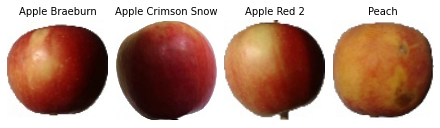

In [37]:
fig, axs = plt.subplots(1, 4,constrained_layout=True)
for i in range(4):
    axs[i].axis('off')
    axs[i].imshow(fruit_images[i*200])
    axs[i].set_title(id_to_label_dict[label_ids[i*200]],fontdict={'weight':'normal','size': 10})
fig.savefig("ImageFour/example.svg",bbox_inches = 'tight',format='svg')

## PCA降维

In [9]:
# 生成图片向量
scaler = StandardScaler() # 数据归一化
images_scaled = scaler.fit_transform([i.flatten() for i in fruit_images])

In [10]:
# PCA降维
pca = PCA(n_components=10)
pca_result = pca.fit_transform(images_scaled)

## 降维可视化

In [11]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

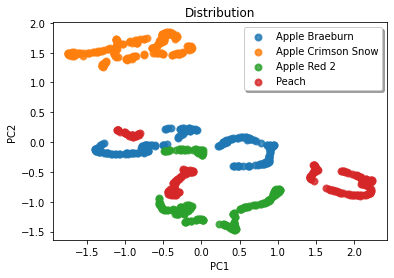

In [12]:
# 分布图
cmap = plt.cm.get_cmap("jet", len(np.unique(label_ids)))
data_2d = tsne_result_scaled
for i, label_id in enumerate(np.unique(label_ids)):
    plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                data_2d[np.where(label_ids == label_id), 1],
                marker='o',
                cmap=cmap(i),
                linewidth=2,
                alpha=0.8,
                label=id_to_label_dict[label_id])
plt.legend(shadow=True, ncol=1)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Distribution')
plt.savefig("ImageFour/TSNE.svg",bbox_inches = 'tight',format='svg')
plt.show()

In [13]:
data = pd.concat([pd.DataFrame(pca_result), pd.DataFrame(label_ids,columns=['label'])], axis=1)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,label
0,-47.228477,-100.133847,45.148065,10.928920,14.380683,10.081618,20.413926,11.357573,-18.295424,7.693161,0
1,24.999174,-110.263826,31.297644,-23.992224,-3.127692,3.644626,-5.598721,-17.711333,1.728142,-6.585865,0
2,28.223779,-114.928199,24.321860,-36.092866,-1.928560,2.943291,-5.927153,-6.997016,2.965416,-6.051975,0
3,29.286895,-118.130954,22.334259,-35.262927,-0.415516,5.498135,-7.728422,-3.905285,5.195180,-2.795357,0
4,30.144339,-118.917120,22.583146,-33.910374,0.335742,6.315565,-8.507610,-3.555407,6.079587,-2.288185,0


In [14]:
X = data.loc[:, data.columns != 'label']
Y = data.loc[:,'label']

# 交叉验证

In [15]:
k = 10
kf = KFold(n_splits=k,shuffle=True)
accuracies = []
tprs1 = []
aucs1 = []
mean_fpr1 = np.linspace(0, 1, 100)
i = 0

for train_index, test_index in kf.split(data):  # 拆分

    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    model = SVC()  # 模型原型 选择
    model.fit(x_train, y_train)  # 训练
    y_predict = model.predict(x_test)  # 预测
    
    accuracy = accuracy_score(y_pred=y_predict, y_true=y_test)
    accuracies.append(accuracy)
    i += 1

# 平均错误率
print("average: {0:.2f}%".format(100*np.mean(accuracies)))

average: 99.88%


## 选择超参数

#### 1. 验证曲线

In [16]:
param_name="gamma"
if param_name=="gamma":
    param_range = np.logspace(-6, -1, 5)
else:
    param_range = np.logspace(-2, 4, 5)

In [17]:
train_scores, test_scores = validation_curve(
    SVC(), X, Y, param_name=param_name, param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)

In [18]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

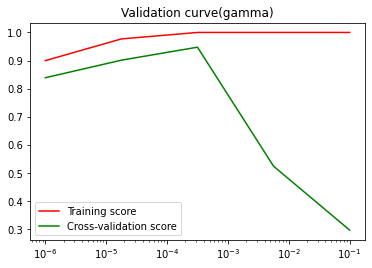

In [19]:
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.title("Validation curve({0})".format(param_name))
plt.legend()
plt.savefig("ImageFour/validation_curve_{0}.svg".format(param_name),bbox_inches = 'tight',format='svg')
plt.show()

#### 2. grid search 

In [20]:
from sklearn.model_selection import GridSearchCV

model=SVC(kernel='rbf')
# 调超参数的列表
param_grid={'C':[1,10,100],'gamma':[1e-4,1e-3]} 

grid_search=GridSearchCV(model,param_grid,n_jobs=8,verbose=1,cv=5)
grid_search.fit(X, Y)
best_parameters=grid_search.best_estimator_.get_params()
print("best parameters are" % grid_search.best_params_)
for para,val in list(best_parameters.items()):
    print(para,val)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best parameters are
C 1
break_ties False
cache_size 200
class_weight None
coef0 0.0
decision_function_shape ovr
degree 3
gamma 0.0001
kernel rbf
max_iter -1
probability False
random_state None
shrinking True
tol 0.001
verbose False


## 支持向量机模型

In [21]:
svm_clf = SVC(kernel='rbf',C=best_parameters['C'],gamma=best_parameters['gamma'],probability=True)
svm_clf.fit(X, Y) 

SVC(C=1, gamma=0.0001, probability=True)

In [22]:
svm_default = SVC(probability=True)
svm_default.fit(X, Y) 

SVC(probability=True)

## 在测试数据集上测试

In [23]:
validation_fruit_images = []
validation_labels = [] 
path_head="Test50\\"
for fruit_name in fruit_names:
    fruit_dir_path = path_head+fruit_name
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        validation_fruit_images.append(image)
        validation_labels.append(fruit_label)
validation_fruit_images = np.array(validation_fruit_images)
validation_labels = np.array(validation_labels)

In [24]:
validation_label_ids = np.array([label_to_id_dict[x] for x in validation_labels])
validation_images_scaled = scaler.transform([i.flatten() for i in validation_fruit_images])
validation_pca_result = pca.transform(validation_images_scaled)

In [31]:
# 默认参数模型测试
test_predictions = svm_default.predict(validation_pca_result)
precision = accuracy_score(test_predictions, validation_label_ids)
print("Validation Accuracy with svm_default: {0:.4f}".format(precision))

Validation Accuracy with svm_default: 0.9150


In [26]:
# 调参后的模型测试
test_predictions = svm_clf.predict(validation_pca_result)
precision = accuracy_score(test_predictions, validation_label_ids)
print("Validation Accuracy with svm_clf: {0:.4f}".format(precision))

Validation Accuracy with svm_clf: 0.9400


## 测试两种模型的平均识别率

In [27]:
import os, random
path_head="Test"
def TestWorkFlow(picknumber):
    # 1 获取测试集
    validation_fruit_images = []
    validation_labels = [] 
    for fruit_name in fruit_names:
        fruit_dir_path = "{0}/{1}/".format(path_head,fruit_name)
        pathDir = os.listdir(fruit_dir_path)    #取图片的原始路径
        filenumber=len(pathDir) # 源文件夹图片数量
        sample = random.sample(pathDir, picknumber)  #随机选取picknumber数量的样本图片
        for name in sample:
            image_path = "{0}{1}".format(fruit_dir_path,name)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            validation_fruit_images.append(image)
            validation_labels.append(fruit_name)
    validation_fruit_images = np.array(validation_fruit_images)
    validation_labels = np.array(validation_labels)
    validation_label_ids = np.array([label_to_id_dict[x] for x in validation_labels])
    validation_images_scaled = scaler.transform([i.flatten() for i in validation_fruit_images])
    validation_pca_result = pca.transform(validation_images_scaled)
    # 默认参数模型测试v
    test_predictions = svm_default.predict(validation_pca_result)
    precision_default = accuracy_score(test_predictions, validation_label_ids)
    # 调参后的模型测试
    test_predictions = svm_clf.predict(validation_pca_result)
    precision_clf = accuracy_score(test_predictions, validation_label_ids)
    return [precision_default,precision_clf]

In [28]:
resy1=[]
resy2=[]
picknumber=50
x = range(0,10,1)
# 10轮训练取平均
for i in x:
    y1,y2 = TestWorkFlow(picknumber)
    resy1.append(y1)
    resy2.append(y2)
print(np.mean(resy1))
print(np.mean(resy2))

0.8965
0.9199999999999999


## 学习曲线

In [29]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.savefig("ImageFour/learning_curve.svg",bbox_inches = 'tight',format='svg')
    

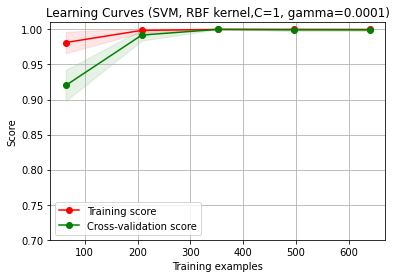

In [30]:
title = "Learning Curves (SVM, RBF kernel,C={0}, gamma={1})".format(best_parameters['C'],best_parameters['gamma'])
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel='rbf' ,C=best_parameters['C'],gamma=best_parameters['gamma'],probability=True)    # 建模
plot_learning_curve(estimator, title, X, Y, (0.7, 1.01), cv=cv, n_jobs=1)

SVM模型上训练集的准确率很高，交叉验证集的准确率也随着数据量增加而增加，在样本数达到250以后收敛。总的来说，该模型在此数据集上表现良好。